<a href="https://colab.research.google.com/github/mohd-faizy/04P_Classify_Radio_Signals_from_Outer_Space_using_Keras/blob/master/04_Classify_Signals_from_Outer_Space_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Classify Signals from Outer Space with Keras__

> The Goal of this project is $\Rightarrow$ How we can treat the __Time Series Forecast__ problems such as __Signal Processing__ & Transform them to image classification problem & then solve them using __CNNs__ [__Keras__] insted of using __Recurrent Neural Networks (RNNs).__

<center><img src='http://blog.yavilevich.com/wp-content/uploads/2016/08/fosphor2-cut.png' width=700 height=200></center>

### __SETI Dataset:__ [__Click here__](https://drive.google.com/file/d/1R2BlsYydirhMmf89_D1imOT5aVvkXHi2/view?usp=sharing)

In [ ]:
# Mounting the Drive to Google colab
from google.colab import drive
drive.mount('/content/drive')



```
!unzip -uq "source" -d "destination"
```



In [2]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/7_Coursera_Projects_Network/04_Classify_Signals_from_Outer_Space_with_Keras/dataset.zip" -d "/content/sample_data"

In [3]:
# Changing the working directory
import os
os.chdir('/content/sample_data')

## __Installing the Dependencies__

In [ ]:
pip install livelossplot

# __1. Importing Libraries__

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


# __2. Load and Preprocess SETI Data__

In [6]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', header=None)

val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header=None)

In [54]:
# All the values in the image.csv are normalised to lie in range 0 & 1
train_images.head(10) # No Column Name - These are all Pixel intensity values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412
5,0.694118,0.682353,0.705882,0.705882,0.666667,0.694118

In [8]:
train_labels.head(5) # SETI has encode them as OneHot Vectors

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [9]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


> __64 x 128 = 8192 Width * height matrix i.e the dimension of the images here__

### __Reshaping the Images for both Training and Validation__

In [10]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

- `train_images` is a __Pandas Dataframe__ and we want to shape the __numpy__ array, so we need to type the values, so that we can get an N-dim __Numpy Array__ and then we added `.shape()`  to shape it.

- _(training_Examples=3200, width=64, heght=128, Channel information=1)_

- Since of this information is been converted to __2D__ Spectrogram, Hence we don't have any __RGB__ information

# __3. Plot 2D Spectrograms__

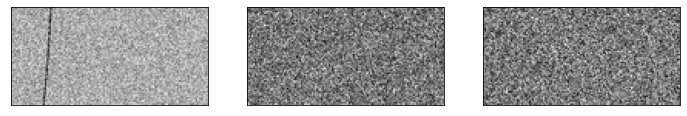

In [53]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

- Creatingg One subPlot with 3 images in them, This is achived by looping the range(1, 4)

- Then Using Matplotlib subplot helper function with 1 rows and 3 column

- Then we create the image for our numpy array

- `np.squeez` is used to remove the extra axis i.e  the cahnnel inforamtion `(800, 64, 128, 1)` hence numpy is used to remove that additional axis

- Then we set the xticks & yticks as a blank list.

- Every output image corrospond to an class i.e squgel, narrow band or Noise.

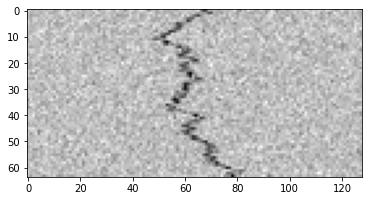

In [12]:
# Setting the color_map argument to gray Scale images
plt.imshow(np.squeeze(x_train[3]), cmap='gray')

# __4. Create Training and Validation Data Generators__

$\color{red}{\textbf{NOTE:}}$ Our __Data__ is already __Normalise__ hence no __Normalization__ is required.

In [13]:
# Performing the Keras Preprocessing
# Only one aspect Data Augmentation is Performed
# i.e ->> Randomly fliping the images along the Horizontal axis
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fitting the DataGenerator so that it can learn the Statistics and properties about the training images
datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip = True)
datagen_val.fit(x_val)

USe the Following command to genrate the documentation `ImageDataGenerator?` 

# __5. Creating the CNN Model__

In [14]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

- Filter/Kernal = 5 x 5
- Input Channel = 1 corresponding to the Gray scale Images
- We need 32 different feature Maps i,e 32 different 
- Output of CNNs = 64 x 128 x 32

In [15]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32, (5,5), padding = 'same', input_shape = (64, 128, 1))) # '1' for greyscale Image
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))      # Since we are using the larger Number or Neurons
                             # Hence we are setting a higher Dropout Regularization rate

# Adding the last dense Output layer ->> SOFTMAX

model.add(Dense(4, activation = 'softmax')) # '4' as output has 4 classes

# 6. __Learning Rate Scheduling and Compile the Model__

In [47]:
# Scheduling the Learning Rate
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = 5,
    decay_rate = 0.96,
    staircase = True
)

# SettingUp the optimizer 
opt = Adam(learning_rate = lr_schedule)

In [48]:
# Compiling Our Model
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

# __7. Training the Model__

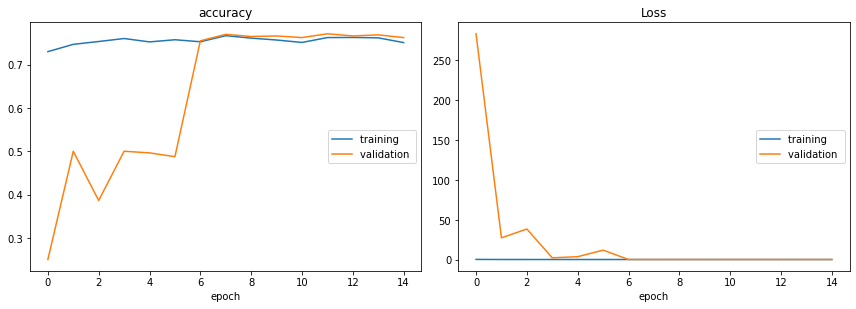

accuracy
	training         	 (min:    0.730, max:    0.767, cur:    0.751)
	validation       	 (min:    0.250, max:    0.771, cur:    0.762)
Loss
	training         	 (min:    0.356, max:    0.474, cur:    0.362)
	validation       	 (min:    0.355, max:  283.397, cur:    0.356)

Epoch 00015: saving model to model_weights.h5
100/100 [==============================] - 5s 55ms/step - loss: 0.3623 - accuracy: 0.7509 - val_loss: 0.3556 - val_accuracy: 0.7625


In [49]:
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Creating the checkpoints i.e Saving the weights with maximum Validation accuracy
checkpoint = ModelCheckpoint('model_weights.h5',
                             monitor = 'val_accuracy',
                             save_weights_only = True,
                             mode = 'max',
                             verbose = 1)

# Callbacks
my_callbacks = [PlotLossesKerasTF(), checkpoint]

batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs = 15,
    callbacks = my_callbacks
)

# __8. Model Evaluation__

In [50]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 0s 16ms/step - loss: 0.3558 - accuracy: 0.7663


[0.3558097779750824, 0.7662500143051147]

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       0.53      0.57      0.55       200
           2       0.53      0.50      0.52       200
           3       1.00      1.00      1.00       200

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.77       800
weighted avg       0.77      0.77      0.77       800

Classification accuracy: 0.766250


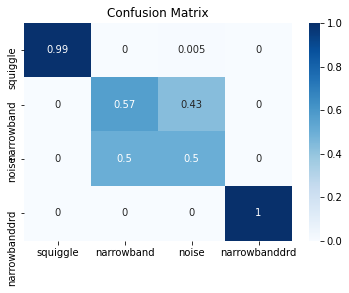

In [52]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);